In [30]:
suppressMessages(library(dplyr))
library(ggplot2)

Get the data we require: constituency election results from 2015 and 2017 from [Electoral Calculus](http://electoralcalculus.co.uk), and EU Referendum result and constituency mappings from [the UK Electoral Commission](https://www.electoralcommission.org.uk/find-information-by-subject/elections-and-referendums/upcoming-elections-and-referendums/eu-referendum/electorate-and-count-information).

In [36]:
mapping <- read.csv('../brexit/LAD12_PCON12_UK_LU.csv')
if (length(Sys.glob('electdata_2015.txt')) == 0) system('wget http://www.electoralcalculus.co.uk/electdata_2015.txt')
if (length(Sys.glob('electdata_2017.txt')) == 0) system('wget http://www.electoralcalculus.co.uk/electdata_2017.txt')
if (length(Sys.glob('../brexit/EU-referendum-result-data.csv')) == 0) system('wget https://www.electoralcommission.org.uk/__data/assets/file/0014/212135/EU-referendum-result-data.csv')
res15 <- read.csv('electdata_2015.txt',sep=';')
res17 <- read.csv('electdata_2017.txt',sep=';')
brexit <- read.csv('../brexit/EU-referendum-result-data.csv')

Combine the data sources and calculate party vote changes.

In [37]:
res17 <- merge(res17, mapping[,c('LAD12CD','PCON12NM')], by.x='Name', by.y='PCON12NM', all.x=TRUE)
res17 <- merge(res17, brexit, by.x='LAD12CD', by.y='Area_Code', all.x=TRUE)

print(sum(is.na(res17$Pct_Leave)))  #Miss multiple areas due to name differences, but enough to get trend
res17 <- subset(res17, !is.na(Pct_Leave))

#average over multiple brexit vote areas in single constituency
res17 <- res17 %>% group_by(Name) %>% summarise(CON=mean(CON),LAB=mean(LAB),LIB=mean(LIB),
                                                UKIP=mean(UKIP),Green=mean(Green),
                                                NAT=mean(NAT),MIN=mean(MIN),OTH=mean(OTH),
                                                Electorate=mean(Electorate.x),
                                                Pct_Leave = mean(Pct_Leave),
                                                Pct_Remain = mean(Pct_Remain),
                                                Region = first(Region.y))
res17 <- subset(res17, !is.na(Region))

res17 <- merge(res17, res15, by='Name', suffixes=c('','_prev'))

for (party in c('CON','LAB','LIB','UKIP','Green','NAT','MIN','OTH')) {
    res17[paste0(party,'_chg')] <- res17[party] - res17[paste0(party,'_prev')]
}

[1] 152


Calculate the swing from **Leave**-supporting parties to broadly (pre-referendum) **Remain**-supporting parties (*NAT* covers the SNP and PC).

In [38]:
res17$RemainSwing <- ((res17$LAB_chg + res17$LIB_chg + res17$Green_chg + res17$NAT_chg) -
    (res17$CON_chg + res17$UKIP_chg))
res17$RemainSwingPct <- 100 * res17$RemainSwing / res17$Electorate

RemainSwingPct is generally positive in England and Wales (towards Labour) but negative in Scotland (away from the SNP), so model separately in each region. Plot results along with the simple regression model.

                            (Intercept) Pct_Remain:I(Region == "Scotland")FALSE 
                              0.2961751                               0.2040498 
 Pct_Remain:I(Region == "Scotland")TRUE 
                             -0.3071154 


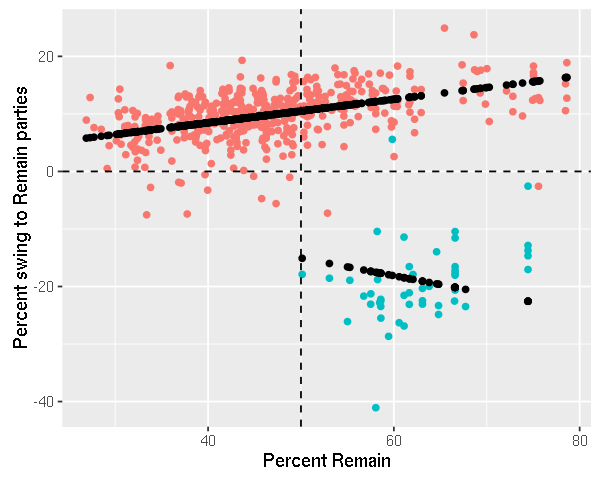

In [41]:
swing <- lm(RemainSwingPct ~ Pct_Remain:I(Region=='Scotland'), data=res17)
print(coef(swing))
#Coefficients are +0.20 %swing/%leave for England and -0.31 %swing/%leave.
#  Scottish constits generally swung away from NAT; dependence on Pct_Remain
#  looks pretty weak actually.
#  English constits swung toward LAB, and most so in strongest Remain areas.

res17$pred <- predict(swing, res17)
options(repr.plot.width=5, repr.plot.height=4)
ggplot(res17) + geom_point(aes(Pct_Remain,RemainSwingPct,colour=Region=='Scotland')) + 
    geom_point(aes(Pct_Remain,pred),colour='black') +
    geom_hline(yintercept=0,linetype=2) + geom_vline(xintercept=50,linetype=2) +
    labs(x='Percent Remain',y='Percent swing to Remain parties') + guides(colour=FALSE)

The swing away from Leave parties was stronger where the Remain vote was strongest in 2016: 0.2% swing for each additional point Remain. Since the makeup of these constituencies was largely identical in 2015, this means that Remain supporters either came out in greater numbers in 2017 or consciously shifted towards more pro-Europe parties (with the caveat that Labour's position is now technically pro-Brexit).

In Scotland the dependence on Remain percentage is less convincing; there was a general swing from Conservative to SNP.